
# YOLO — Analyse Validation par **Augmentation** (9 variantes, seed_02)

Structure attendue :
```
YOLO-Parameters/
  Group1-Light-Small/seed_02/results.csv
  Group1-Light-Medium/seed_02/results.csv
  ...
  Group3-Structural-Strong/seed_02/results.csv
```
Le notebook auto‑découvre les dossiers `Group*`, lit `seed_02/results.csv`, agrège les métriques (dernière epoch ou meilleure mAP50‑95) et génère : summary CSV, bar charts, courbe d'évolution.



## 1) Configuration


In [40]:

from pathlib import Path

BASE_DIR = Path("/Users/benoitmoedts/Thesis/all_results/results/Augmentations/YOLO-Parameters") 
# Chemin vers le CSV baseline (sans augmentation)
BASELINE_CSV = Path("/Users/benoitmoedts/Thesis/all_results/results/Augmentations/YOLO-Parameters/Baseline/seed_02/results.csv")  # <-- adapte si besoin
 # <-- ajustez si besoin
SEED_DIR_NAME = "seed_02"
CSV_FILENAME = "results.csv"
SELECT_LAST_EPOCH = False

SAVE_DIR = Path("analysis_outputs_aug")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

print("BASE_DIR     :", BASE_DIR.resolve())
print("SEED_DIR     :", SEED_DIR_NAME)
print("CSV_FILENAME :", CSV_FILENAME)
print("SELECT_LAST_EPOCH:", SELECT_LAST_EPOCH)
print("Exports  ->  :", SAVE_DIR.resolve())


BASE_DIR     : /Users/benoitmoedts/Thesis/all_results/results/Augmentations/YOLO-Parameters
SEED_DIR     : seed_02
CSV_FILENAME : results.csv
SELECT_LAST_EPOCH: False
Exports  ->  : /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug



## 2) Chargement & agrégation


In [41]:

import re
import pandas as pd
import numpy as np

def parse_group_folder_name(name: str):
    m = re.match(r"Group(\d+)-([A-Za-z]+)-([A-Za-z]+)", name)
    if m:
        gid, fam, intensity = m.groups()
        return int(gid), fam, intensity
    parts = name.split('-')
    gid = None
    fam = None
    intensity = None
    if parts and parts[0].startswith("Group"):
        try:
            gid = int(re.sub(r"[^0-9]", "", parts[0]))
        except:
            gid = None
    if len(parts) >= 2:
        fam = parts[1]
    if len(parts) >= 3:
        intensity = parts[2]
    return gid, fam, intensity

def read_one_results_csv(csv_path: Path, select_last: bool = True):
    df = pd.read_csv(csv_path)
    map_col = next((c for c in df.columns if "mAP50-95" in c and "(B)" in c), None)
    map50_col = next((c for c in df.columns if "mAP50(" in c and "(B)" in c), None)
    prec_col = next((c for c in df.columns if "precision" in c and "(B)" in c), None)
    rec_col = next((c for c in df.columns if "recall" in c and "(B)" in c), None)

    train_box = next((c for c in df.columns if c.endswith("train/box_loss")), None)
    train_cls = next((c for c in df.columns if c.endswith("train/cls_loss")), None)
    val_box = next((c for c in df.columns if c.endswith("val/box_loss")), None)
    val_cls = next((c for c in df.columns if c.endswith("val/cls_loss")), None)

    if select_last or map_col is None:
        row = df.iloc[-1]
    else:
        row = df.loc[df[map_col].idxmax()]

    map50_95 = float(row[map_col]) if (map_col and map_col in row) else np.nan
    map50 = float(row[map50_col]) if (map50_col and map50_col in row) else np.nan
    precision = float(row[prec_col]) if (prec_col and prec_col in row) else np.nan
    recall = float(row[rec_col]) if (rec_col and rec_col in row) else np.nan
    f1 = (2*precision*recall)/(precision+recall) if (precision+recall)>0 else np.nan

    train_loss = (float(row.get(train_box, np.nan)) + float(row.get(train_cls, 0.0))) if train_box else np.nan
    val_loss = (float(row.get(val_box, np.nan)) + float(row.get(val_cls, 0.0))) if val_box else np.nan

    return {
        "map50_95": map50_95,
        "map50": map50,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "epochs": len(df)
    }

records = []
group_dirs = [p for p in BASE_DIR.iterdir() if p.is_dir() and p.name.startswith("Group")]

for gdir in sorted(group_dirs, key=lambda p: p.name):
    gid, fam, intensity = parse_group_folder_name(gdir.name)
    csv_path = gdir / SEED_DIR_NAME / CSV_FILENAME
    if not csv_path.exists():
        print("[WARN] CSV manquant:", csv_path)
        continue
    vals = read_one_results_csv(csv_path, SELECT_LAST_EPOCH)
    rec = {
        "group_folder": gdir.name,
        "group_id": gid,
        "family": fam,
        "intensity": intensity,
        "csv_path": str(csv_path.resolve()),
    }
    rec.update(vals)
    records.append(rec)

summary = pd.DataFrame(records).sort_values(["group_id","family","intensity"]).reset_index(drop=True)
# --- AJOUT DU BASELINE ---
if 'BASELINE_CSV' in locals() and BASELINE_CSV and BASELINE_CSV.exists():
    vals = read_one_results_csv(BASELINE_CSV, SELECT_LAST_EPOCH)
    base_rec = {
        "group_folder": "Baseline",
        "group_id": 0,
        "family": "Baseline",
        "intensity": "None",
        "csv_path": str(BASELINE_CSV.resolve()),
    }
    base_rec.update(vals)
    # Concaténer au summary existant
    summary = pd.concat([summary, pd.DataFrame([base_rec])], ignore_index=True)

# Sauvegarde mise à jour
summary_path = SAVE_DIR / "summary_aug_seed02_with_baseline.csv"
summary.to_csv(summary_path, index=False)
display(summary.sort_values("map50_95", ascending=False))
print("Résumé sauvegardé ->", summary_path.resolve())



,group_folder,group_id,family,intensity,csv_path,map50_95,map50,precision,recall,f1,train_loss,val_loss,epochs
8,Group3-Structural-Strong,3,Structural,Strong,/Users/benoitmoedts/Thesis/all_results/results...,0.68674,0.92706,0.90451,0.88270,0.893472,2.09922,3.39309,136
7,Group3-Structural-Small,3,Structural,Small,/Users/benoitmoedts/Thesis/all_results/results...,0.68408,0.91920,0.89837,0.87167,0.884819,2.13053,3.32118,81
6,Group3-Structural-Medium,3,Structural,Medium,/Users/benoitmoedts/Thesis/all_results/results...,0.68312,0.92816,0.90606,0.87840,0.892016,1.93934,3.41719,150
3,Group2-Geometric-Medium,2,Geometric,Medium,/Users/benoitmoedts/Thesis/all_results/results...,0.68228,0.93045,0.89689,0.88943,0.893144,2.45391,3.29560,93
10,Group4-Mix-Small,4,Mix,Small,/Users/benoitmoedts/Thesis/all_results/results...,0.67376,0.94898,0.89513,0.91014,0.902573,2.75543,3.36171,107
9,Group4-Mix-Medium,4,Mix,Medium,/Users/benoitmoedts/Thesis/all_results/results...,0.67227,0.94728,0.90481,0.90611,0.905460,3.52460,3.34292,94
4,Group2-Geometric-Small,2,Geometric,Small,/Users/benoitmoedts/Thesis/all_results/results...,0.66496,0.93505,0.92721,0.88414,0.905163,2.00048,3.44290,103
5,Group2-Geometric-Strong,2,Geometric,Strong,/Users/benoitmoedts/Thesis/all_results/results...,0.65882,0.94921,0.90968,0.92117,0.915389,2.31688,3.38920,118
12,Baseline,0,Baseline,None,/Users/benoitmoedts/Thesis/all_results/results...,0.65368,0.89731,0.86676,0.85741,0.862060,1.83779,3.54568,65
2,Group1-Light-Strong,1,Light,Strong,/Users/benoitmoedts/Thesis/all_results/results...,0.65264,0.89087,0.85827,0.84396,0.851055,1.34640,3.73478,99


Résumé sauvegardé -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/summary_aug_seed02_with_baseline.csv


In [42]:

import pandas as pd

# Affiche directement le tableau
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
display(summary)

# Sauvegarde le CSV
summary_path = SAVE_DIR / "summary_aug_seed02.csv"
summary.to_csv(summary_path, index=False)
print("Résumé sauvegardé ->", summary_path.resolve())

,group_folder,group_id,family,intensity,csv_path,map50_95,map50,precision,recall,f1,train_loss,val_loss,epochs
0,Group1-Light-Medium,1,Light,Medium,/Users/benoitmoedts/Thesis/all_results/results...,0.63390,0.88243,0.85049,0.84396,0.847212,1.75811,3.74910,68
1,Group1-Light-Small,1,Light,Small,/Users/benoitmoedts/Thesis/all_results/results...,0.64935,0.88987,0.88359,0.85042,0.866688,1.57038,3.56785,76
2,Group1-Light-Strong,1,Light,Strong,/Users/benoitmoedts/Thesis/all_results/results...,0.65264,0.89087,0.85827,0.84396,0.851055,1.34640,3.73478,99
3,Group2-Geometric-Medium,2,Geometric,Medium,/Users/benoitmoedts/Thesis/all_results/results...,0.68228,0.93045,0.89689,0.88943,0.893144,2.45391,3.29560,93
4,Group2-Geometric-Small,2,Geometric,Small,/Users/benoitmoedts/Thesis/all_results/results...,0.66496,0.93505,0.92721,0.88414,0.905163,2.00048,3.44290,103
5,Group2-Geometric-Strong,2,Geometric,Strong,/Users/benoitmoedts/Thesis/all_results/results...,0.65882,0.94921,0.90968,0.92117,0.915389,2.31688,3.38920,118
6,Group3-Structural-Medium,3,Structural,Medium,/Users/benoitmoedts/Thesis/all_results/results...,0.68312,0.92816,0.90606,0.87840,0.892016,1.93934,3.41719,150
7,Group3-Structural-Small,3,Structural,Small,/Users/benoitmoedts/Thesis/all_results/results...,0.68408,0.91920,0.89837,0.87167,0.884819,2.13053,3.32118,81
8,Group3-Structural-Strong,3,Structural,Strong,/Users/benoitmoedts/Thesis/all_results/results...,0.68674,0.92706,0.90451,0.88270,0.893472,2.09922,3.39309,136
9,Group4-Mix-Medium,4,Mix,Medium,/Users/benoitmoedts/Thesis/all_results/results...,0.67227,0.94728,0.90481,0.90611,0.905460,3.52460,3.34292,94


Résumé sauvegardé -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/summary_aug_seed02.csv


In [43]:
import matplotlib.pyplot as plt

# Palette fixe par nom de groupe/famille+intensité
COLOR_MAP = {
    "Baseline-None": "#888888",     # rouge
    "Group1-Light-Strong": "#F39C12",       # orange
    "Group1-Light-Medium": "#F5B041",      # orange clair
    "Group1-Light-Small": "#F8C471",      # beige
    "Group2-Geometric-Small": "#3498DB",   # bleu clair
    "Group2-Geometric-Medium": "#2874A6",  # bleu moyen
    "Group2-Geometric-Strong": "#1B4F72",  # bleu foncé
    "Group3-Structural-Small": "#2ECC71",  # vert clair
    "Group3-Structural-Medium": "#27AE60", # vert moyen
    "Group3-Structural-Strong": "#145A32", # vert foncé
}

COLOR_MAP2 = {
    "Baseline-None": "#888888",     # rouge
    "Light-Strong": "#F39C12",       # orange
    "Light-Medium": "#F5B041",      # orange clair
    "Light-Small": "#F8C471",      # beige
    "Geometric-Small": "#3498DB",   # bleu clair
    "Geometric-Medium": "#2874A6",  # bleu moyen
    "Geometric-Strong": "#1B4F72",  # bleu foncé
    "Structural-Small": "#2ECC71",  # vert clair
    "Structural-Medium": "#27AE60", # vert moyen
    "Structural-Strong": "#145A32", # vert foncé
}


## 4) Vue globale (9 variantes) — tri par métrique


map50_95


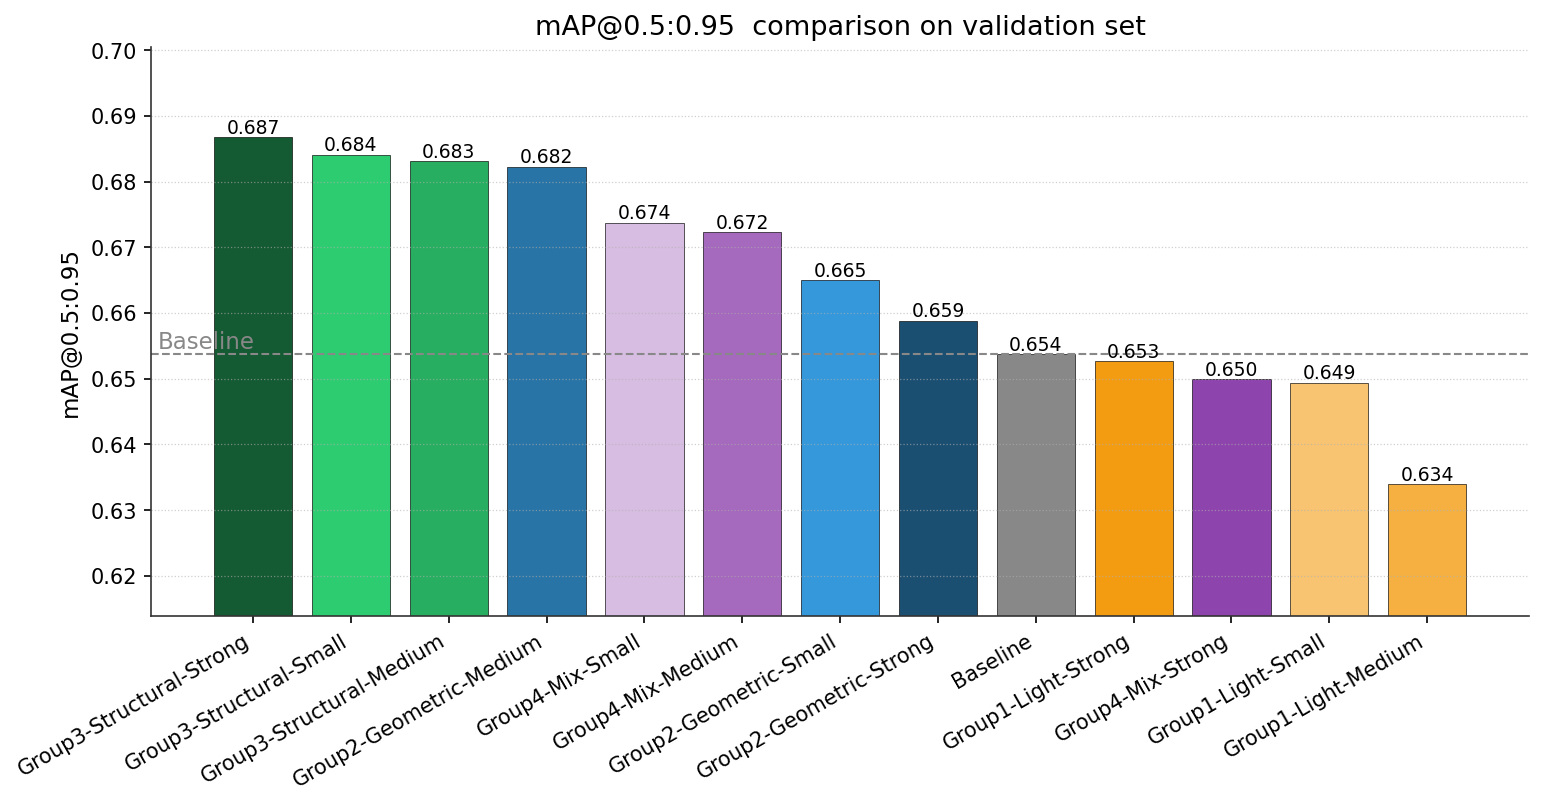

Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/mAP@0.5:0.95_global_sorted.png
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/mAP@0.5:0.95_global_sorted.pdf
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/mAP@0.5:0.95_global_sorted.svg
map50


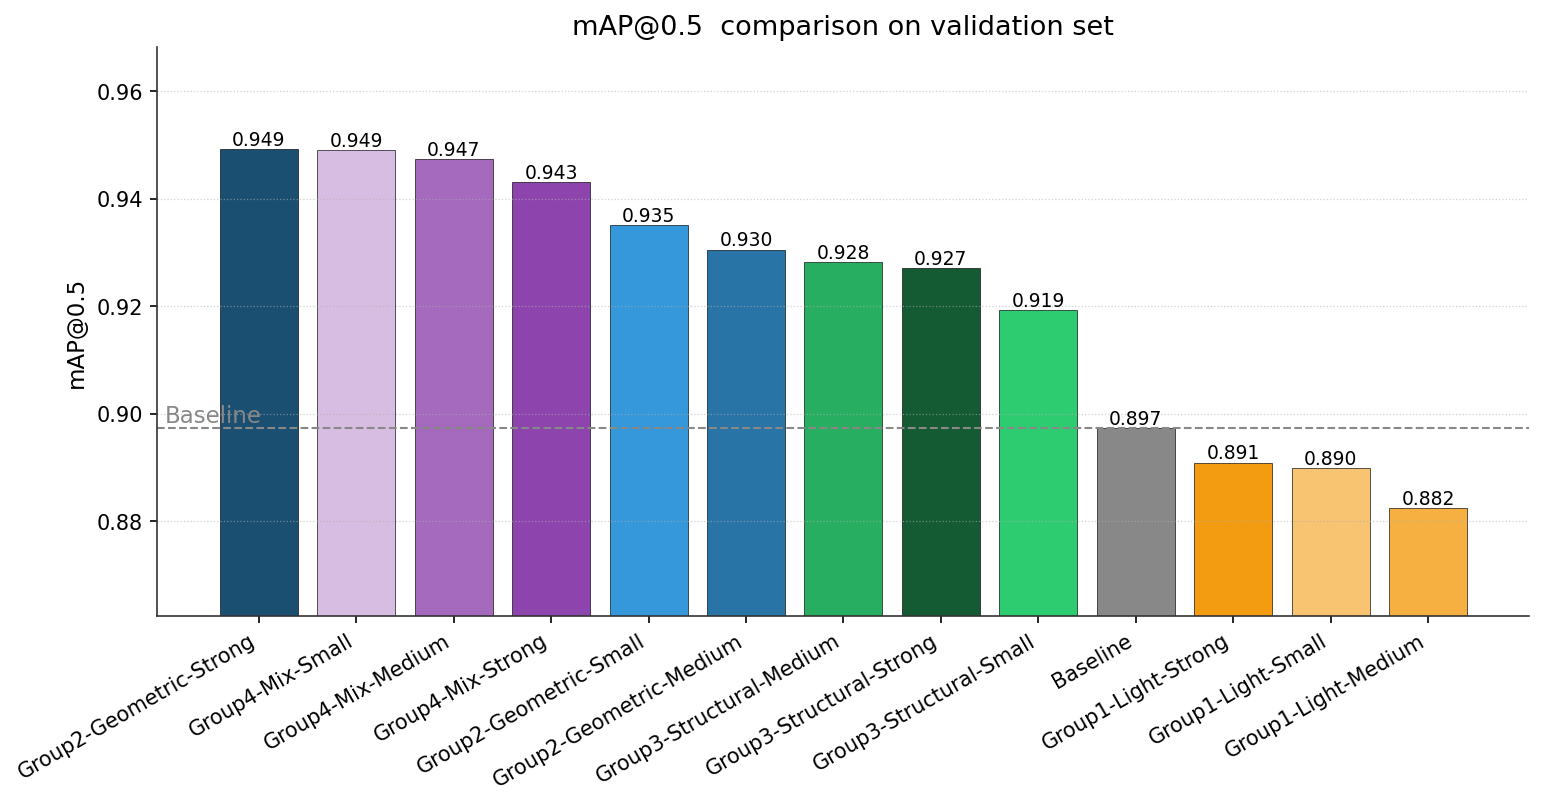

Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/mAP@0.5_global_sorted.png
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/mAP@0.5_global_sorted.pdf
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/mAP@0.5_global_sorted.svg
precision


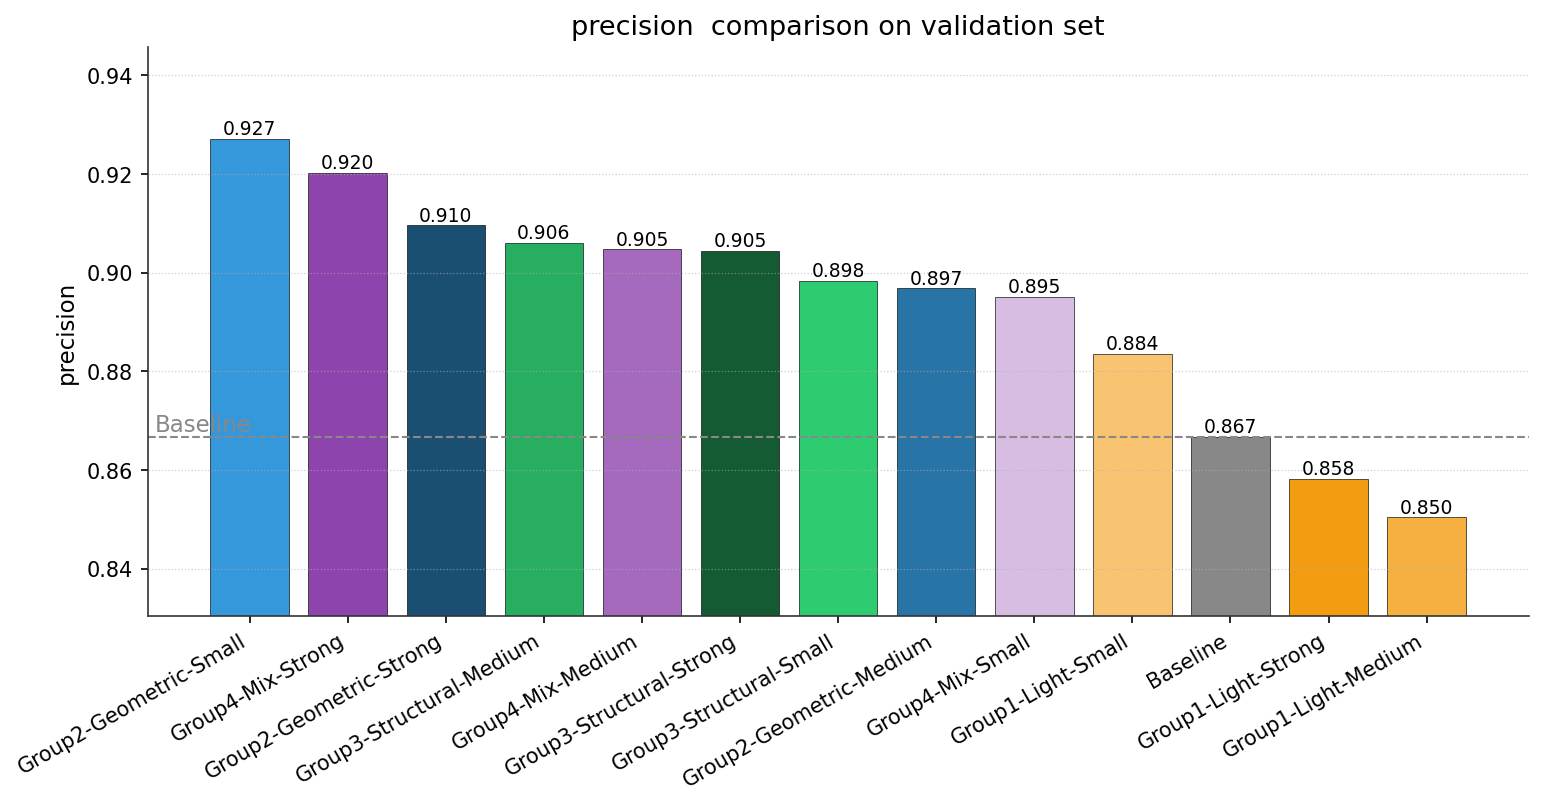

Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/precision_global_sorted.png
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/precision_global_sorted.pdf
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/precision_global_sorted.svg
recall


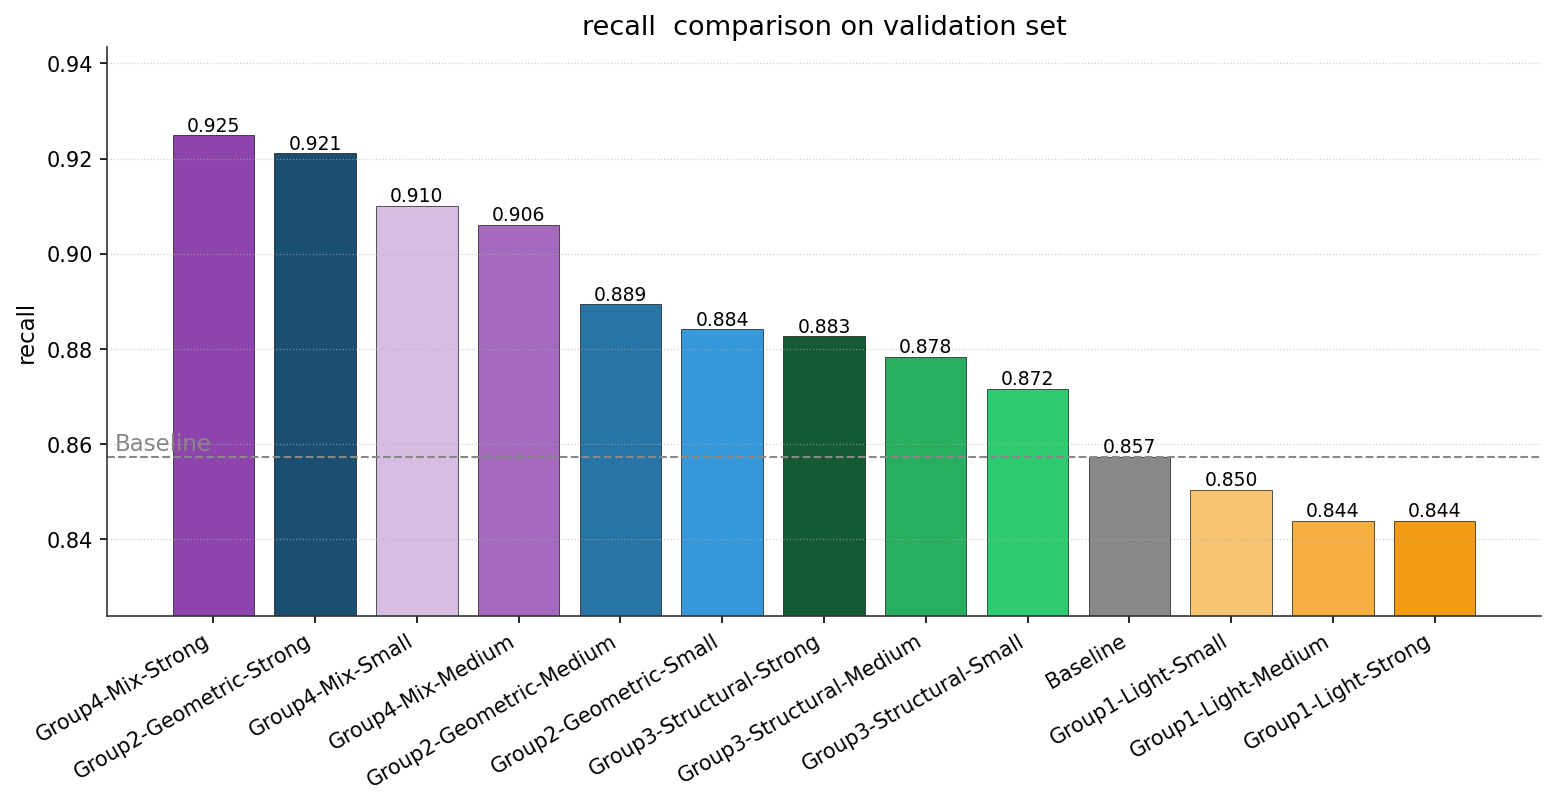

Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/recall_global_sorted.png
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/recall_global_sorted.pdf
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/recall_global_sorted.svg
f1


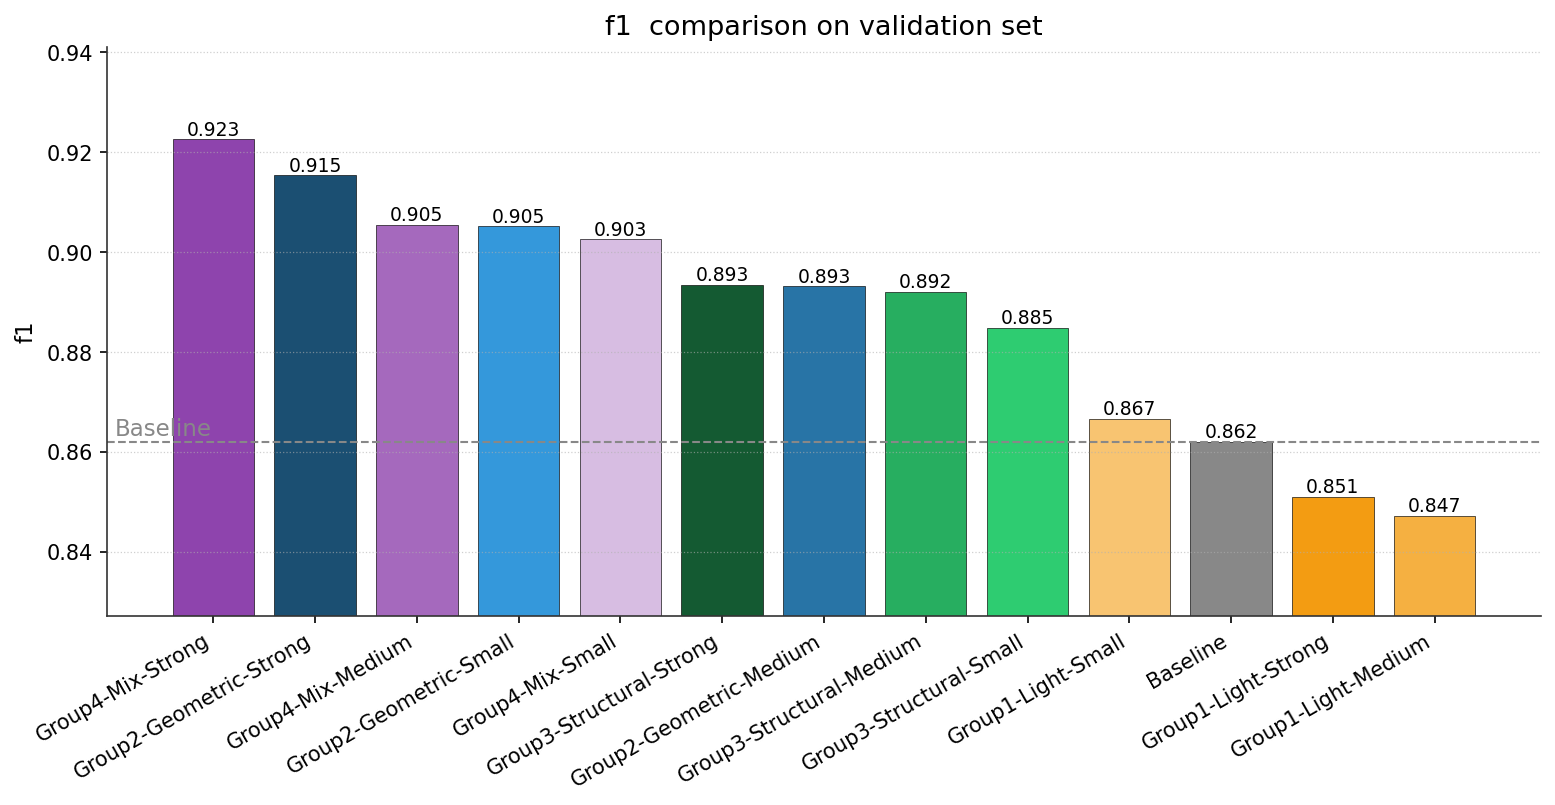

Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/f1_global_sorted.png
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/f1_global_sorted.pdf
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/f1_global_sorted.svg


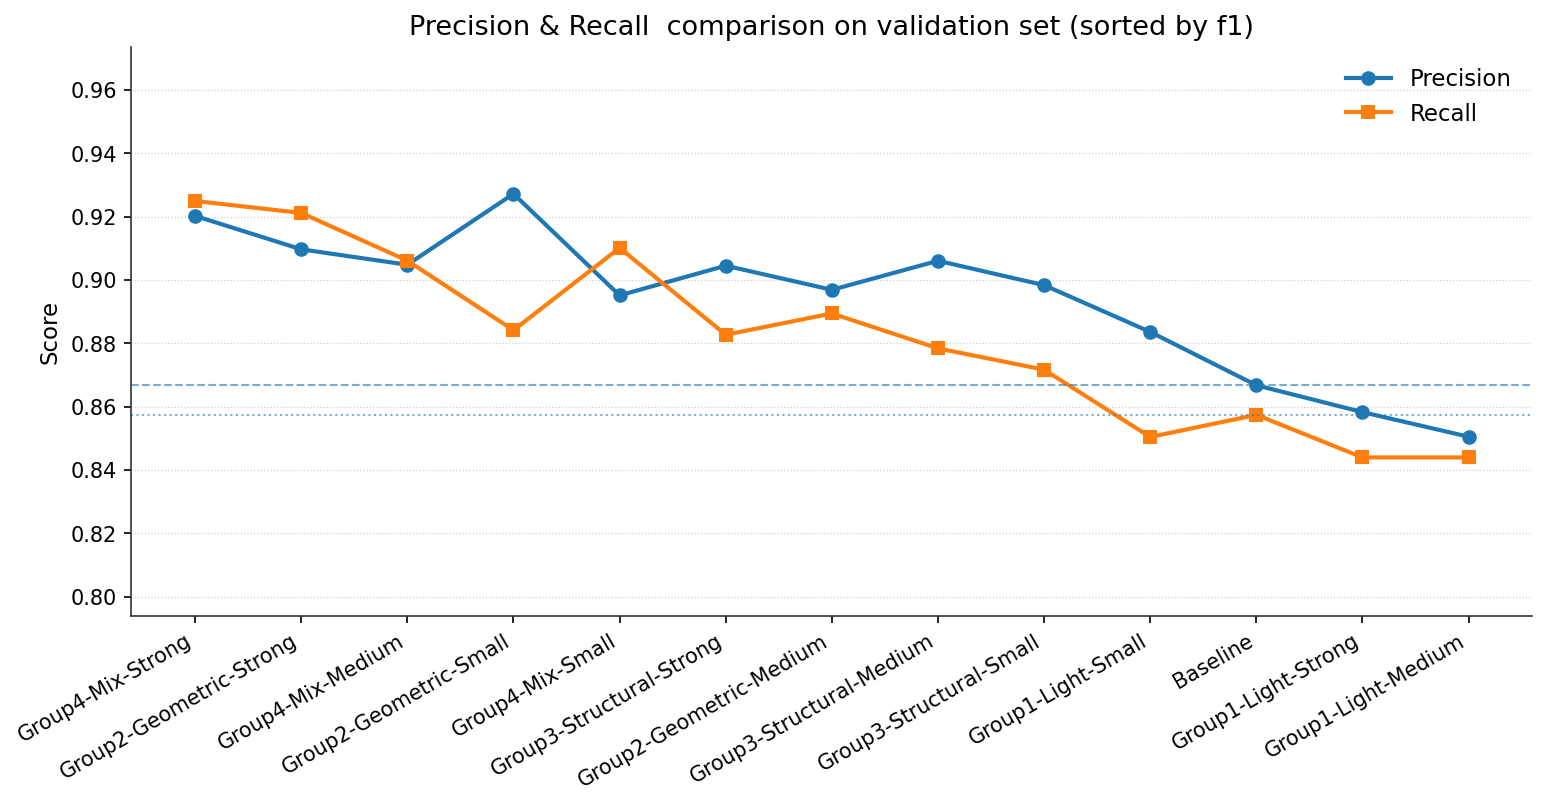

Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/precision_recall_line_sorted_by_f1.png
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/precision_recall_line_sorted_by_f1.pdf
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/precision_recall_line_sorted_by_f1.svg


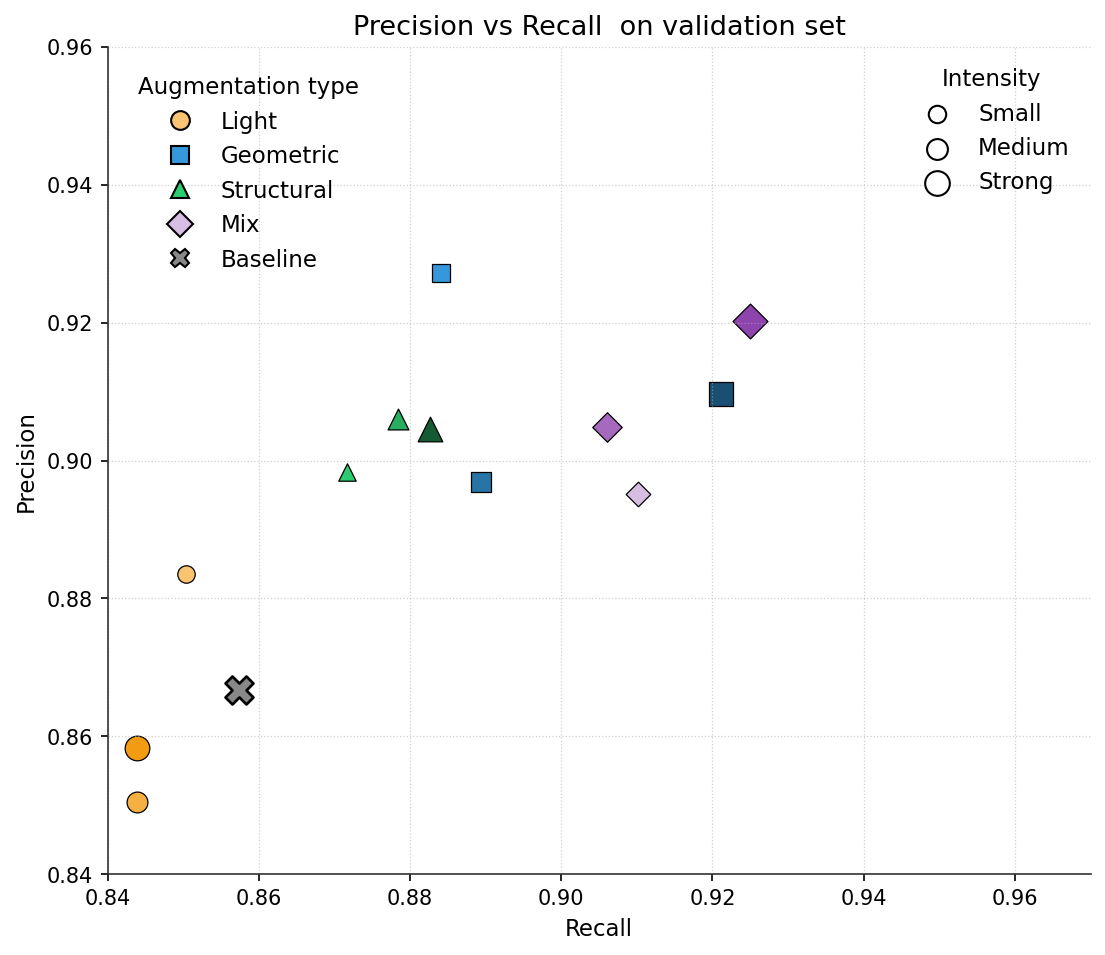

In [61]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# ——— Style global "report" (lisible à l'impression)
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# Palette cohérente (même que line-plot)
COLOR_MAP = {
    "Baseline-None": "#888888",     # rouge
    "Light-Strong": "#F39C12",       # orange
    "Light-Medium": "#F5B041",      # orange clair
    "Light-Small": "#F8C471",      # beige
    "Geometric-Small": "#3498DB",   # bleu clair
    "Geometric-Medium": "#2874A6",  # bleu moyen
    "Geometric-Strong": "#1B4F72",  # bleu foncé
    "Structural-Small": "#2ECC71",  # vert clair
    "Structural-Medium": "#27AE60", # vert moyen
    "Structural-Strong": "#145A32",
    "Mix-Strong": "#8E44AD",       # mauve foncé
    "Mix-Medium": "#A569BD",      # mauve clair
    "Mix-Small": "#D7BDE2",      # mauve très clair
}

def _color_key_from_groupfolder(label: str) -> str:
    # "Group3-Structural-Strong" -> "Structural-Strong"
    if label.lower().startswith("baseline"):
        return "Baseline-None"
    parts = label.split("-")
    if len(parts) >= 3:
        return f"{parts[1]}-{parts[2]}"
    return label  # fallback

def _percent_formatter(x, pos):
    return f"{x:.0f}"

def plot_global_sorted(df, metric, title_suffix=""):
    
    sub = df.copy().sort_values(metric, ascending=False)
    labels = sub["group_folder"].values
    vals = sub[metric].astype(float).values  # Pour repère baseline
    base_rows = sub[sub["group_folder"].str.lower().str.startswith("baseline")]
    base_val = float(base_rows.iloc[0][metric]) if not base_rows.empty else None

    fig = plt.figure(figsize=(10.5, 5.5))
    ax = plt.gca()

    x = np.arange(len(sub))
    bars = []
    for i, (label, val) in enumerate(zip(labels, vals)):
        color_key = _color_key_from_groupfolder(label)
        color = COLOR_MAP.get(color_key, "#888888")
        b = ax.bar(x[i], val, color=color, edgecolor="black", linewidth=0.3)
        bars.append(b)
    print(metric)
    if metric == "map50":
        metric = "mAP@0.5"
    if metric == "map50_95":
        metric = "mAP@0.5:0.95"
    # X labels raccourcis mais suffisamment explicites
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")

    # Titre & axes
    ax.set_title(f"{metric} {title_suffix} comparison on validation set")
    ax.set_ylabel(metric)
    ax.set_ylim(vals.min() - 0.02, max(vals.max()*1.02, 0.01))  # petit headroom

    # Ligne repère baseline
    if base_val is not None:
        ax.axhline(base_val, linestyle="--", linewidth=1.0, color=COLOR_MAP.get("Baseline-None", "#E74C3C"))
        # Annotation discrète
        ax.text(0.005, (base_val-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]) + 0.01,
                "Baseline", color=COLOR_MAP["Baseline-None"], transform=ax.transAxes)

    # Grille légère uniquement sur Y
    ax.grid(axis="y", linestyle=":", linewidth=0.6, alpha=0.6)

    # Nettoyage des spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # Valeurs au-dessus des barres
    for rect in ax.patches:
        h = rect.get_height()
        if np.isnan(h):
            continue
        txt = f"{h:.3f}" if (0 <= h <= 1) else f"{h:.3f}"
        ax.text(rect.get_x() + rect.get_width()/2, h,
                txt, ha="center", va="bottom", fontsize=9, rotation=0)

    plt.tight_layout()

    # Exports haute qualité
    out_png = graphs_dir / f"{metric}_global_sorted.png"
    out_pdf = graphs_dir / f"{metric}_global_sorted.pdf"
    out_svg = graphs_dir / f"{metric}_global_sorted.svg"
    plt.savefig(out_png)
    plt.savefig(out_pdf)
    plt.savefig(out_svg)
    plt.show()
    print("Saved ->", out_png.resolve())
    print("Saved ->", out_pdf.resolve())
    print("Saved ->", out_svg.resolve())

def plot_precision_recall_line_sorted(df, sort_by="f1", title_suffix=""):
    """
    Line chart combiné Precision + Recall.
    X = configurations (group_folder), triées par sort_by (défaut: f1).
    Y = score en %.
    """
    sub = df.copy().sort_values(sort_by, ascending=False)

    labels = sub["group_folder"].values
    prec = sub["precision"].astype(float).values
    rec  = sub["recall"].astype(float).values

    x = np.arange(len(sub))

    # Baseline repère (si présent)
    base_rows = sub[sub["group_folder"].str.lower().str.startswith("baseline")]
    base_prec = float(base_rows.iloc[0]["precision"]) if not base_rows.empty else None
    base_rec  = float(base_rows.iloc[0]["recall"]) if not base_rows.empty else None

    fig = plt.figure(figsize=(10.5, 5.5))
    ax = plt.gca()

    # Courbes (couleurs sobres + marqueurs distincts)
    ax.plot(x, prec, marker="o", linewidth=2.0, label="Precision")
    ax.plot(x, rec,  marker="s", linewidth=2.0, label="Recall")

    # X labels
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")

    ax.set_title(f"Precision & Recall {title_suffix} comparison on validation set (sorted by {sort_by})")
    ax.set_ylabel("Score")

    # Format % si dans [0,1]
    if (np.nanmin([prec.min(), rec.min()]) >= 0.0) and (np.nanmax([prec.max(), rec.max()]) <= 1.0):
        ymin = min(prec.min(), rec.min()) - 0.05
        ymax = max(prec.max(), rec.max()) * 1.05
        ax.set_ylim(ymin, max(ymax, 0.01))

    # Lignes repères baseline (optionnel, discret)
    if base_prec is not None:
        ax.axhline(base_prec, linestyle="--", linewidth=1.0, alpha=0.6)
    if base_rec is not None:
        ax.axhline(base_rec, linestyle=":", linewidth=1.0, alpha=0.6)

    # Grille Y
    ax.grid(axis="y", linestyle=":", linewidth=0.6, alpha=0.6)

    # Nettoyage spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.legend(frameon=False)

    plt.tight_layout()

    # Exports
    out_png = graphs_dir / f"precision_recall_line_sorted_by_{sort_by}.png"
    out_pdf = graphs_dir / f"precision_recall_line_sorted_by_{sort_by}.pdf"
    out_svg = graphs_dir / f"precision_recall_line_sorted_by_{sort_by}.svg"
    plt.savefig(out_png)
    plt.savefig(out_pdf)
    plt.savefig(out_svg)
    plt.show()
    print("Saved ->", out_png.resolve())
    print("Saved ->", out_pdf.resolve())
    print("Saved ->", out_svg.resolve())


# Forme = type d'augmentation
MARKER_MAP = {
    "Baseline-None": "X",
    "Light": "o",        # cercle
    "Geometric": "s",    # carré
    "Structural": "^",   # triangle
    "Mix": "D",          # losange
}

# Taille = intensité
SIZE_MAP = {
    "Small": 70,
    "Medium": 100,
    "Strong": 140,
}

def plot_precision_recall_scatter(df, title_suffix=""):
    fig = plt.figure(figsize=(7.5, 6.5))
    ax = plt.gca()

    for _, row in df.iterrows():
        label = row["group_folder"]
        p = float(row["precision"])
        r = float(row["recall"])

        color_key = _color_key_from_groupfolder(label)
        color = COLOR_MAP.get(color_key, "#888888")

        # Baseline
        if label.lower().startswith("baseline"):
            ax.scatter(
                r, p,
                s=180,
                marker=MARKER_MAP["Baseline-None"],
                color=color,
                edgecolor="black",
                linewidth=1.3,
            )
            continue

        # "Group3-Structural-Strong" → Structural / Strong
        parts = label.split("-")
        aug_type = parts[1]
        intensity = parts[2]

        marker = MARKER_MAP.get(aug_type, "o")
        size = SIZE_MAP.get(intensity, 100)

        ax.scatter(
            r, p,
            s=size,
            marker=marker,
            color=color,
            edgecolor="black",
            linewidth=0.6
        )

    # Axes
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision vs Recall {title_suffix} on validation set")

    ax.set_xlim(0.84, 0.97)
    ax.set_ylim(0.84, 0.96)

    # Grille
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

    # Nettoyage spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # Légendes (formes + tailles)
    _add_shape_legend(ax)
    _add_size_legend(ax)


    plt.tight_layout()

    out_png = graphs_dir / "precision_vs_recall_scatter.png"
    out_pdf = graphs_dir / "precision_vs_recall_scatter.pdf"
    out_svg = graphs_dir / "precision_vs_recall_scatter.svg"
    plt.savefig(out_png)
    plt.savefig(out_pdf)
    plt.savefig(out_svg)
    plt.show()



from matplotlib.lines import Line2D

from matplotlib.lines import Line2D

def _add_shape_legend(ax):
    handles = [
        Line2D(
            [0], [0],
            marker="o",
            linestyle="",
            label="Light",
            markerfacecolor=COLOR_MAP["Light-Small"],
            markeredgecolor="black",
            markersize=9
        ),
        Line2D(
            [0], [0],
            marker="s",
            linestyle="",
            label="Geometric",
            markerfacecolor=COLOR_MAP["Geometric-Small"],
            markeredgecolor="black",
            markersize=9
        ),
        Line2D(
            [0], [0],
            marker="^",
            linestyle="",
            label="Structural",
            markerfacecolor=COLOR_MAP["Structural-Small"],
            markeredgecolor="black",
            markersize=9
        ),
        Line2D(
            [0], [0],
            marker="D",
            linestyle="",
            label="Mix",
            markerfacecolor=COLOR_MAP["Mix-Small"],
            markeredgecolor="black",
            markersize=9
        ),
        Line2D(
            [0], [0],
            marker="X",
            linestyle="",
            label="Baseline",
            markerfacecolor=COLOR_MAP["Baseline-None"],
            markeredgecolor="black",
            markersize=9
        ),
    ]

    leg = ax.legend(
        handles=handles,
        title="Augmentation type",
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(0.01, 0.99)
    )
    ax.add_artist(leg)
  

def _add_size_legend(ax):
    handles = [
        plt.scatter([], [], s=SIZE_MAP["Small"],  edgecolors="black", facecolors="white", label="Small"),
        plt.scatter([], [], s=SIZE_MAP["Medium"], edgecolors="black", facecolors="white", label="Medium"),
        plt.scatter([], [], s=SIZE_MAP["Strong"], edgecolors="black", facecolors="white", label="Strong"),
    ]
    ax.legend(
        handles=handles,
        title="Intensity",
        frameon=False,
        loc="upper right"
    )





for met in ["map50_95", "map50", "precision", "recall", "f1"]:
    plot_global_sorted(summary, met)

plot_precision_recall_line_sorted(summary, sort_by="f1")
plot_precision_recall_scatter(summary)




## 5) Évolution mAP50‑95 par epoch (seed_02)


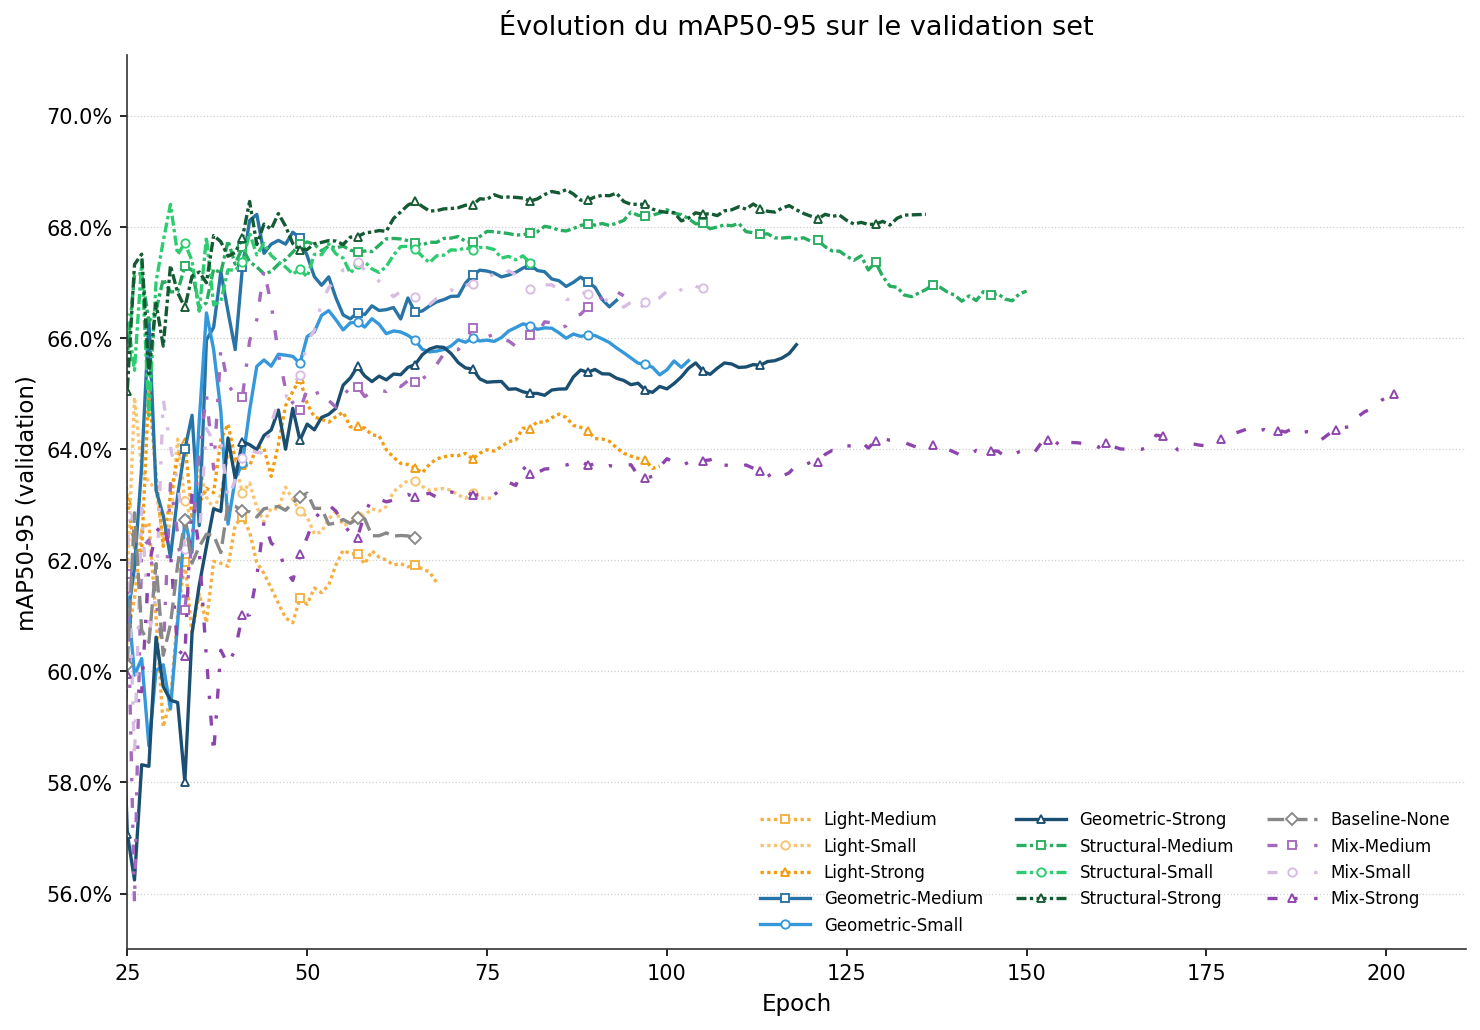

✅ 13 courbes tracées
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/map50_95_evolution_seed02_hybrid.png
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/map50_95_evolution_seed02_hybrid.pdf
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/map50_95_evolution_seed02_hybrid.svg


In [45]:
import pandas as pd
import matplotlib.ticker as mtick
from pathlib import Path
import matplotlib.pyplot as plt

# === Figure ===
fig, ax = plt.subplots(figsize=(10, 7))

# === Fonction utilitaire pour trouver la colonne ===
def find_map_col(cols):
    for c in cols:
        if any(k in c for k in ["mAP50-95", "map50_95"]):
            return c
    return None

# === Styles combinés : couleur + différenciation N&B ===
LINESTYLE_BY_FAMILY = {
    "Light":        (0, (1, 1)),          # pointillé fin
    "Geometric":    "-",                  # trait plein
    "Structural":   (0, (3, 1, 1, 1)),    # trait-point-point
    "Baseline":     (0, (5, 2)),          # tirets espacés
    "Mix":          (0, (3, 5, 1, 5)),    # long-trait-espace-point-espace
}
MARKER_BY_INTENSITY = {
    "Small":  "o",
    "Medium": "s",
    "Strong": "^",
    "None":   "D",
}

# Palette couleur principale (tu peux la garder telle quelle)
COLOR_MAP2 = {
    "Baseline-None": "#888888",     # rouge
    "Light-Strong": "#F39C12",       # orange
    "Light-Medium": "#F5B041",      # orange clair
    "Light-Small": "#F8C471",      # beige
    "Geometric-Small": "#3498DB",   # bleu clair
    "Geometric-Medium": "#2874A6",  # bleu moyen
    "Geometric-Strong": "#1B4F72",  # bleu foncé
    "Structural-Small": "#2ECC71",  # vert clair
    "Structural-Medium": "#27AE60", # vert moyen
    "Structural-Strong": "#145A32",
    "Mix-Strong": "#8E44AD",       # mauve foncé
    "Mix-Medium": "#A569BD",      # mauve clair
    "Mix-Small": "#D7BDE2",      # mauve très clair
}


MARK_EVERY = 8

n_plotted = 0
for _, row in summary.iterrows():
    csv_path = Path(row["csv_path"])
    if not csv_path.exists():
        continue
    df = pd.read_csv(csv_path)

    map_col = find_map_col(df.columns)
    if map_col is None or "epoch" not in df.columns:
        continue

    family = row.get("family", "Other")
    intensity = row.get("intensity", "None")
    label = f"{family}-{intensity}"

    color = COLOR_MAP2.get(label, "#666666")
    ls = LINESTYLE_BY_FAMILY.get(family, "-")
    mk = MARKER_BY_INTENSITY.get(intensity, None)

    ax.plot(
        df["epoch"].values, df[map_col].values,
        label=label,
        color=color,
        linestyle=ls,
        linewidth=1.6,
        marker=mk, markevery=MARK_EVERY, markersize=4,
        markerfacecolor="white", markeredgewidth=0.9,
    )
    n_plotted += 1

# === Mise en forme ===
ax.set_xlabel("Epoch")
ax.set_ylabel("mAP50-95 (validation)")
ax.set_ylim(bottom=0.55)
ax.set_xlim(left=25)
ax.set_title("Évolution du mAP50-95 sur le validation set", pad=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(axis="y", linestyle=":", linewidth=0.6, alpha=0.6)

# Légende propre (triée)
handles, labels = ax.get_legend_handles_labels()
order = ["Light", "Geometric", "Structural", "Baseline"]
labels_sorted = sorted(labels, key=lambda x: order.index(x.split("-")[0]) if x.split("-")[0] in order else 99)
handles_sorted = [handles[labels.index(l)] for l in labels_sorted]
ax.legend(
    handles_sorted, labels_sorted,
    ncol=3, fontsize=8, loc="lower right",
    frameon=False, handlelength=3
)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()

graphs_dir = SAVE_DIR / "graphs"

# === Sauvegardes ===
out_png = graphs_dir / "map50_95_evolution_seed02_hybrid.png"
out_pdf = graphs_dir / "map50_95_evolution_seed02_hybrid.pdf"
out_svg = graphs_dir / "map50_95_evolution_seed02_hybrid.svg"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.savefig(out_pdf, dpi=300, bbox_inches="tight")
plt.savefig(out_svg, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ {n_plotted} courbes tracées")
print("Saved ->", out_png.resolve())
print("Saved ->", out_pdf.resolve())
print("Saved ->", out_svg.resolve())


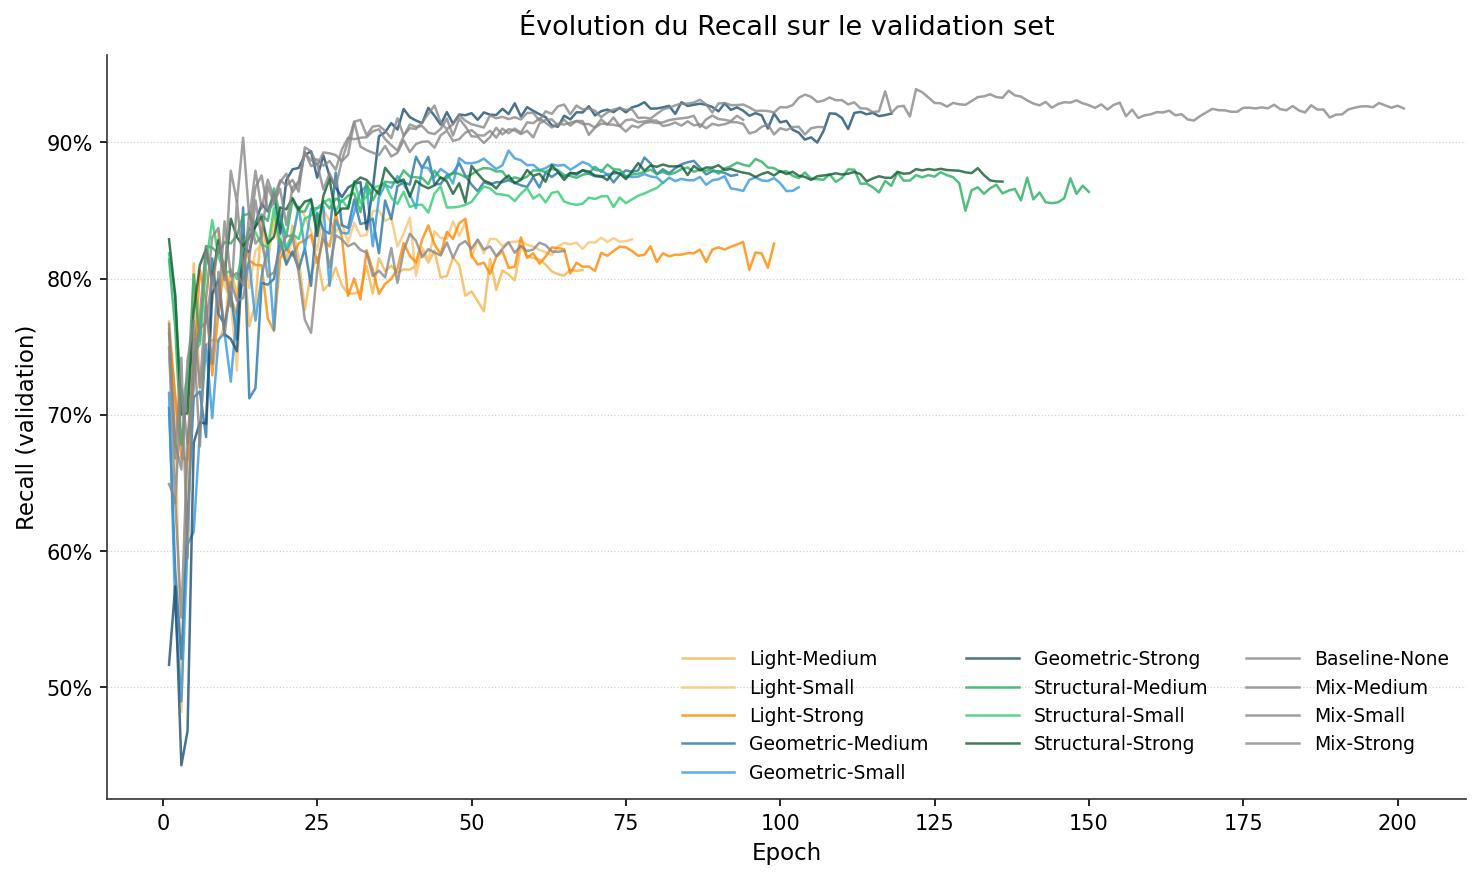

Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/recall_evolution_seed02.png
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/recall_evolution_seed02.pdf
Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/recall_evolution_seed02.svg


In [46]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as mtick

# === STYLE GLOBAL (academic) ===
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.frameon": False,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 0.8,
})

# === Palette cohérente avec barplots ===
COLOR_MAP2 = {
    "Baseline-None": "#888888",     # rouge
    "Light-Strong": "#FF8800",       # orange
    "Light-Medium": "#F5B54E",      # orange clair
    "Light-Small": "#F8C471",      # beige
    "Geometric-Small": "#3498DB",   # bleu clair
    "Geometric-Medium": "#2874A6",  # bleu moyen
    "Geometric-Strong": "#1B4F72",  # bleu foncé
    "Structural-Small": "#2ECC71",  # vert clair
    "Structural-Medium": "#27AE60", # vert moyen
    "Structural-Strong": "#145A32", # vert foncé
}

fig, ax = plt.subplots(figsize=(10, 6))

# --- Courbes principales ---
for _, row in summary.iterrows():
    csv_path = Path(row["csv_path"])
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        map_col = next((c for c in df.columns if "recall" in c and "(B)" in c), None)
        if map_col and "epoch" in df.columns:
            label = f"{row['family']}-{row['intensity']}"
            color = COLOR_MAP2.get(label, "#888888")
            lw = 1.2 if "Strong" in label else 1.2 if "Medium" in label else 1.2
            alpha = 0.8 if "Strong" in label else 0.8
            ax.plot(df["epoch"], df[map_col],
                    label=label, color=color, linewidth=lw, alpha=alpha)

# === Mise en forme ===
ax.set_xlabel("Epoch")
ax.set_ylabel("Recall (validation)")
ax.set_title("Évolution du Recall sur le validation set", pad=10)

# Format en pourcentage (lisible)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Grille légère horizontale
ax.grid(axis="y", linestyle=":", linewidth=0.6, alpha=0.6)

# Légende optimisée
handles, labels = ax.get_legend_handles_labels()
# Tri pour regrouper par famille
sort_order = ["Light", "Geometric", "Structural", "Baseline"]
labels_sorted = sorted(labels, key=lambda x: sort_order.index(x.split("-")[0]) if x.split("-")[0] in sort_order else 99)
handles_sorted = [handles[labels.index(l)] for l in labels_sorted]
ax.legend(handles_sorted, labels_sorted,
          ncol=3, fontsize=9, loc="lower right", frameon=False, handlelength=2.8)

# Nettoyage visuel
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()

# === Export en haute qualité ===
out_png = graphs_dir / "recall_evolution_seed02.png"
out_pdf = graphs_dir / "recall_evolution_seed02.pdf"
out_svg = graphs_dir / "recall_evolution_seed02.svg"
plt.savefig(out_png)
plt.savefig(out_pdf)
plt.savefig(out_svg)
plt.show()
print("Saved ->", out_png.resolve())
print("Saved ->", out_pdf.resolve())
print("Saved ->", out_svg.resolve())


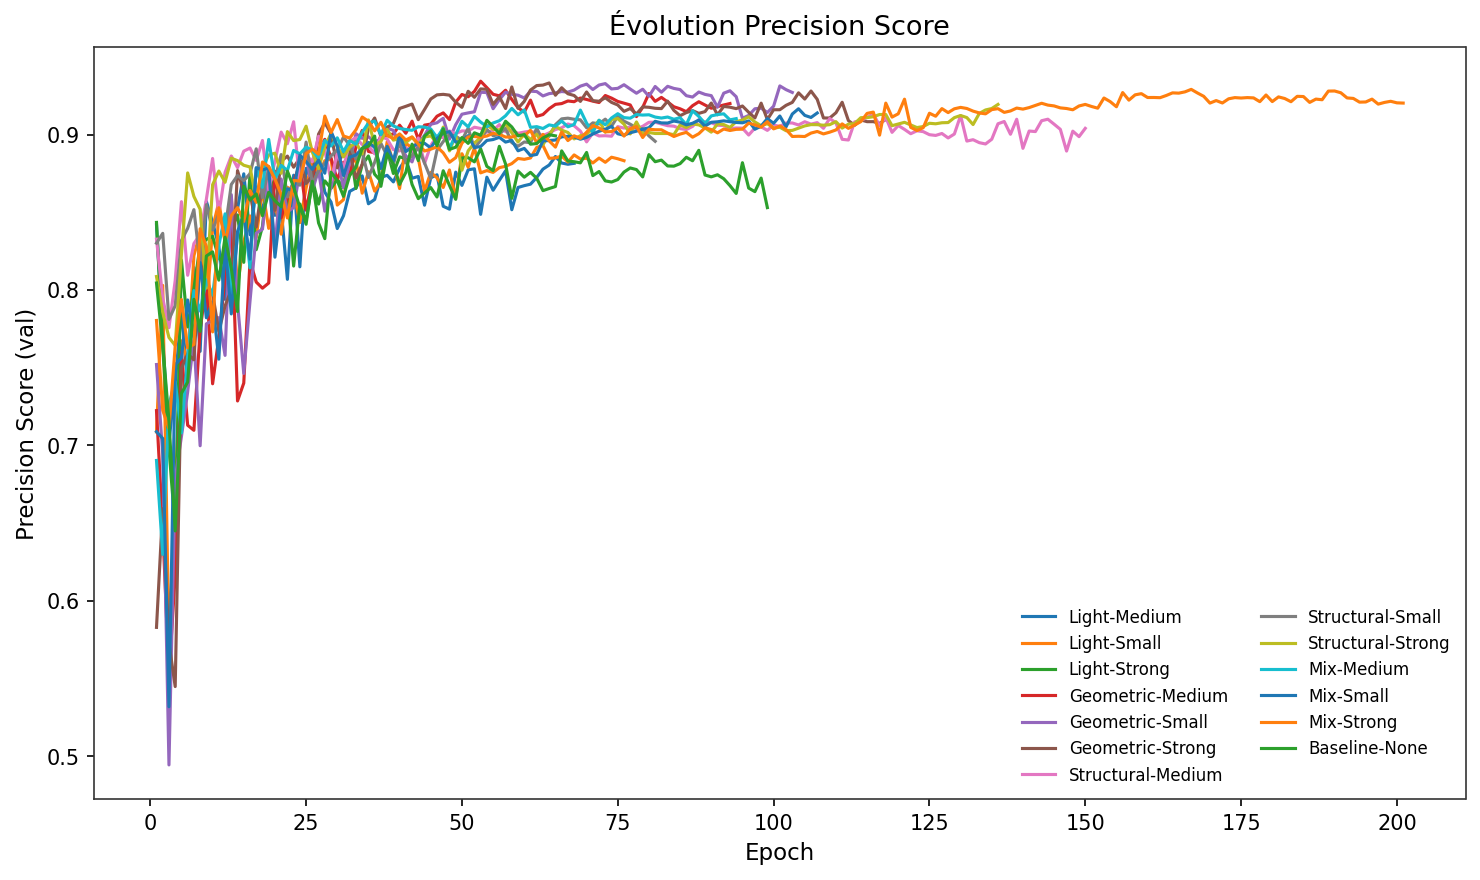

Saved -> /Users/benoitmoedts/Thesis/notebooks/analysis_outputs_aug/graphs/precision_evolution.png


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.figure(figsize=(10,6))

for _, row in summary.iterrows():
    csv_path = Path(row["csv_path"])
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        map_col = next((c for c in df.columns if "precision" in c and "(B)" in c), None)
        if map_col and "epoch" in df.columns:
            label = f"{row['family']}-{row['intensity']}"
            plt.plot(df["epoch"].values, df[map_col].values, label=label)

plt.xlabel("Epoch")
plt.ylabel("Precision Score (val)")
plt.title("Évolution Precision Score")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
out = (graphs_dir / "precision_evolution.png")
plt.savefig(out, dpi=150)
plt.show()
print("Saved ->", out.resolve())


## 6) Exports
- `analysis_outputs_aug/summary_aug_seed02.csv`
- `analysis_outputs_aug/graphs/*.png`
